# Residual Network

以下を再現

http://www2.kaiyodai.ac.jp/~takenawa/learning/10_1ResNet_GPU.html#10.-Residual-Network

### Keras による ResNet の実装

In [1]:
#データ増大（変形）用モジュールの読み込み
!git clone https://github.com/yu4u/cutout-random-erasing ./random_eraser 
                                                      #github から cutout-random-erasingh を random_eraser にコピー

import sys
sys.path.append("/content/random_eraser/")  #モジュールのあるディレクトリを直接指定してパスを通す

Cloning into './random_eraser'...
remote: Enumerating objects: 23, done.
remote: Total 23 (delta 0), reused 0 (delta 0), pack-reused 23
Unpacking objects: 100% (23/23), done.


In [2]:
import tensorflow as tf
import numpy as np
from keras.layers import Input, Conv2D, Add, BatchNormalization, Activation, MaxPooling2D, Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.models import Model, Sequential  #KerasではResNetのように枝分かれを持つネットワークの構成には，Sequentialではなく，Modelというクラスを使用

'''
ResNet18: nb_blocks = [2,2,2,2], wide = 2, nottleneck = False
ResNet34: nb_blocks = [3,4,6,3], wide = 2, nottleneck = False
ResNet50: nb_blocks = [3,4,6,3], wide = 2, nottleneck = True
ResNet101: nb_blocks = [3,4,23,3], wide = 2, nottleneck = True
ResNet152: nb_blocks = [3,8,36,3], wide = 2, nottleneck = True
WideResNet: nb_blocks = [3,3,3], wide >= 3, nottleneck = False  
'''

def resnet(nb_blocks = [3,4,6,3], wide = 2, bottleneck = False):
  input = Input(shape=(32, 32, 3), dtype=tf.float32)
  X = input
  n_filter = 64
  X = Conv2D(n_filter, (3,3),  padding="same",kernel_initializer='he_normal')(X)
   
  shortcut = X
  X = BatchNormalization()(X)
  
  if bottleneck == False:
  
    for i, repete in enumerate(nb_blocks):
      for j in range(repete):     
        if i>0 and j == 0:
          shortcut =  Conv2D(n_filter, (1, 1), strides=(2, 2),
                            kernel_initializer='he_normal')(shortcut)
          X = Activation("relu")(X)
          X = Conv2D(n_filter, (3,3), strides= (2,2), padding="same", kernel_initializer='he_normal')(X)
          X = BatchNormalization()(X)
        
        else:      
          X = Activation("relu")(X)
          X = Conv2D(n_filter, (3,3), padding="same", kernel_initializer='he_normal')(X)
          X = BatchNormalization()(X)
      
        X = Activation("relu")(X)
        X = Conv2D(n_filter, (3,3), padding="same",kernel_initializer='he_normal')(X)
      
        
        # ショートカットとマージ
        X = Add()([X, shortcut])
        shortcut = X
        X = BatchNormalization()(X)
      n_filter *= wide
  
  if bottleneck == True:
    shortcut =  Conv2D(n_filter * 4, (1, 1), kernel_initializer='he_normal')(shortcut)  
    
 
    for i, repete in enumerate(nb_blocks):
      for j in range(repete):
        if i>0 and j == 0:
          shortcut =  Conv2D(n_filter * 4, (1, 1), strides=(2, 2),
                            kernel_initializer='he_normal')(shortcut)
          X = Activation("relu")(X)
          X = Conv2D(n_filter, (1,1), strides= (2,2), padding="same", kernel_initializer='he_normal')(X)
          X = BatchNormalization()(X)
        
        else:
          X = Activation("relu")(X)
          X = Conv2D(n_filter, (1,1), padding="same", kernel_initializer='he_normal')(X)
          X = BatchNormalization()(X)
      
       
        X = Activation("relu")(X)
        X = Conv2D(n_filter, (3,3), padding="same",kernel_initializer='he_normal')(X)
        X = BatchNormalization()(X)
        X = Activation("relu")(X)
        X = Conv2D(n_filter * 4, (1,1), padding="same",kernel_initializer='he_normal')(X)
        
        # ショートカットとマージ
        X = Add()([X, shortcut])
        shortcut = X
        X = BatchNormalization()(X)
      n_filter *= wide

  
  # 全結合
  X = Activation("relu")(X)
  X = GlobalAveragePooling2D()(X)
  X = Dropout(0.5)(X)
  y = Dense(10, activation="softmax")(X)
  # モデル
  model = Model(inputs=[input], outputs=[y])
  return model

Using TensorFlow backend.


In [3]:
import keras.backend as K

K.clear_session()

from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator 
from random_eraser import get_random_eraser # https://github.com/yu4u/cutout-random-erasing 
import os
from keras.optimizers import Adam


# CIFAR
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
x_train, x_test = (X_train / 255.0), (X_test / 255.0)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)  

datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            zca_epsilon=1e-06,  # epsilon for ZCA whitening
            rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
            # randomly shift images horizontally (fraction of total width)
            width_shift_range=0.1,
            # randomly shift images vertically (fraction of total height)
            height_shift_range=0.1,
            shear_range=2.0,  # set range for random shear
            zoom_range=0.1,  # set range for random zoom
            channel_shift_range=0,  # set range for random channel shifts
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            cval=0.,  # value used for fill_mode = "constant"
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False,  # randomly flip images
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function = get_random_eraser(p=0.5, s_l=0.02, s_h=0.1, r_1=0.3, r_2=1/0.3, v_l=0, v_h=0),
            # image data format, either "channels_first" or "channels_last"
            # fraction of images reserved for validation (strictly between 0 and 1)
            validation_split=0.0)

# モデルを作成
#original residual network
model = resnet(nb_blocks = [2,2,2,2], wide = 2, bottleneck = False)

#wide resudual network
#model = wideresnet(nb_blocks = [2,2,2], wide = 2)
model.compile( Adam(lr=1e-3), loss="categorical_crossentropy", 
              metrics=["acc"])




170500096/170498071 [==============================] - 6s 0us/step









Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.





In [4]:
#モデルの構造を可視化
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

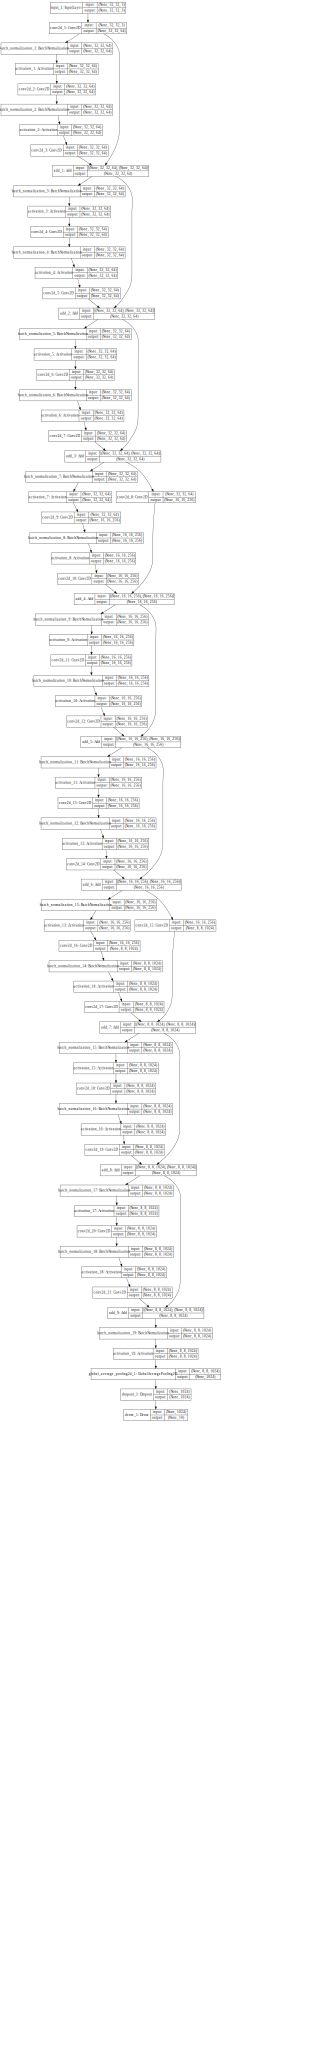

In [23]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes = True, dpi=50).create(prog='dot', format='svg'))

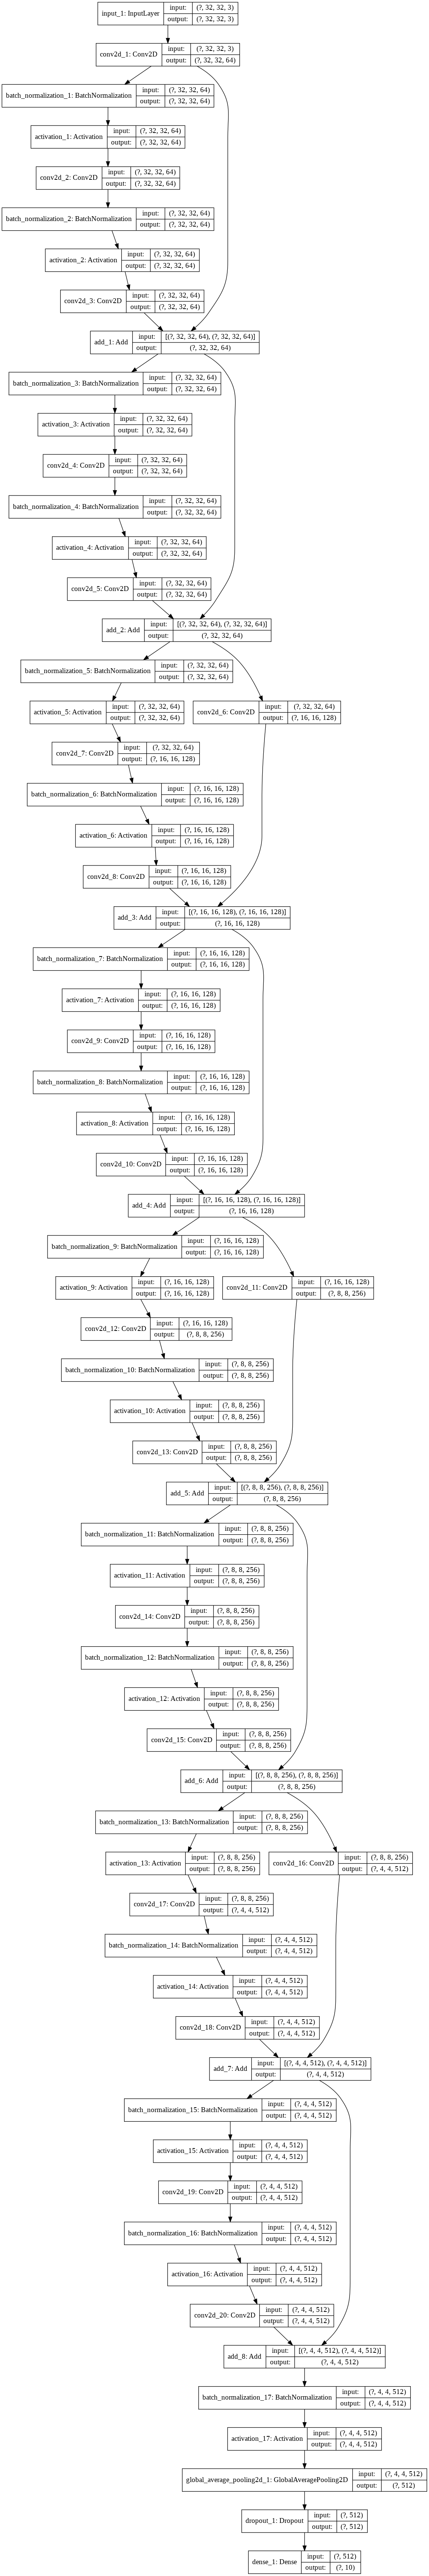

In [6]:
from tensorflow.keras.utils import plot_model
from matplotlib.image import imread

plot_model(model, to_file='model.png', show_shapes = True)

In [7]:
from keras.callbacks import LearningRateScheduler


#schedulerの設定
def step_decay(epoch):
    x = 0.001
    if epoch >= 20: x = 0.0003
    if epoch >= 35: x = 0.0001
    return x
decay = LearningRateScheduler(step_decay, verbose=1)
#datagen.fit(X_train)
#validationgen.fit(x_test)


#データ増大と学習率の変更をしない場合
#history = model.fit(x_train, y_train, batch_size=128, epochs = 10, verbose=1,validation_data=(x_test,y_test))

#データ増大と学習率の変更をする場合
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=128), 
                              steps_per_epoch=len(x_train) // 128, epochs=50, validation_data=(x_test,y_test),callbacks=[decay])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
390/390 [==============================] - 50s 128ms/step - loss: 1.5122 - acc: 0.4515 - val_loss: 1.5739 - val_acc: 0.4976
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
390/390 [==============================] - 39s 101ms/step - loss: 1.0705 - acc: 0.6186 - val_loss: 1.6698 - val_acc: 0.5185
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
390/390 [==============================] - 39s 100ms/step - loss: 0.8724 - acc: 0.6938 - val_loss: 1.0750 - val_acc: 0.6731
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
390/390 [==============================] - 39s 100ms/step - loss: 0.7381 - acc: 0.7439 - val_loss: 0.8220 - val_acc: 0.7317
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.001.
390/390 [====

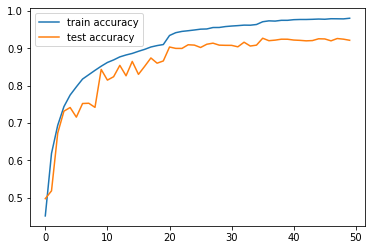

In [8]:
import matplotlib.pyplot as plt


train_acc = history.history['acc']
test_acc = history.history['val_acc']
x = np.arange(len(train_acc))
plt.plot(x, train_acc, label = 'train accuracy')
plt.plot(x, test_acc, label = 'test accuracy')
plt.legend() #グラフの線の説明を表示

In [9]:
print('Predicts are \n',model.predict(x_test[0:50]).argmax(axis = 1))
print('The correct values are \n', y_test[0:50].argmax(axis = 1))

Predicts are 
 [3 8 1 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5 2 4 0 9 6 6 5 4 3 9 8 4
 9 9 5 4 6 5 6 0 9 3 1 7 6]
The correct values are 
 [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5 2 4 0 9 6 6 5 4 5 9 2 4
 1 9 5 4 6 5 6 0 9 3 9 7 6]


In [0]:
model.save_weights('ResNet18_weights.h5')

In [0]:
model.load_weights('ResNet18_weights.h5')

In [0]:
import requests #requests モジュールの読み込み

#ダウンロード
response = requests.get('http://www2.kaiyodai.ac.jp/~takenawa/learning/model/ResNet18_weights.h5', allow_redirects=False)

#ダウンロードしたファイルをResNet18_trained_weight.h5というファイル名で保存
with open('ResNet18_trained_weights.h5', "wb") as fout:
  fout.write(response.content)     

#ウェイトの読み込み
model.load_weights('ResNet18_trained_weights.h5')

In [13]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 3s 312us/step


[0.23147632275298238, 0.9312]

In [0]:
import keras.backend as K

K.clear_session()

from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator 
from random_eraser import get_random_eraser # https://github.com/yu4u/cutout-random-erasing 
import os
from keras.optimizers import Adam


# CIFAR
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
x_train, x_test = (X_train / 255.0), (X_test / 255.0)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)  

datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            zca_epsilon=1e-06,  # epsilon for ZCA whitening
            rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
            # randomly shift images horizontally (fraction of total width)
            width_shift_range=0.1,
            # randomly shift images vertically (fraction of total height)
            height_shift_range=0.1,
            shear_range=2.0,  # set range for random shear
            zoom_range=0.1,  # set range for random zoom
            channel_shift_range=0,  # set range for random channel shifts
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            cval=0.,  # value used for fill_mode = "constant"
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False,  # randomly flip images
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function = get_random_eraser(p=0.5, s_l=0.02, s_h=0.1, r_1=0.3, r_2=1/0.3, v_l=0, v_h=0),
            # image data format, either "channels_first" or "channels_last"
            # fraction of images reserved for validation (strictly between 0 and 1)
            validation_split=0.0)

# モデルを作成
#wide resudual network
model = resnet(nb_blocks = [3,3,3], wide = 4)
model.compile( Adam(lr=1e-3), loss="categorical_crossentropy", 
              metrics=["acc"])

In [0]:
import requests #requests モジュールの読み込み

#ダウンロード
response = requests.get('http://www2.kaiyodai.ac.jp/~takenawa/learning/model/WideResNet4_weights.h5', allow_redirects=False)

#ダウンロードしたファイルをResNet50_trained_weight.h5というファイル名で保存
with open('WideResNet4_trained_weights.h5', "wb") as fout:
  fout.write(response.content)     

#ウェイトの読み込み
model.load_weights('WideResNet4_trained_weights.h5')

In [16]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 8s 819us/step


[0.25770881563327275, 0.9441]

In [17]:
predict = model.predict(x_test[0:100]).argmax(axis = 1)
label = y_test[0:100].argmax(axis = 1)
print('Predicts are \n', predict)
print('The correct values are \n', label)
print( predict-label )

Predicts are 
 [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5 2 4 0 9 6 6 5 4 5 9 2 4
 9 9 5 4 6 5 6 0 9 3 9 7 6 9 8 3 3 8 8 7 7 4 6 7 5 6 3 6 2 1 2 3 7 2 6 8 8
 0 2 9 3 3 8 8 1 1 7 2 5 2 7 8 9 0 3 8 6 4 6 6 0 0 7]
The correct values are 
 [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5 2 4 0 9 6 6 5 4 5 9 2 4
 1 9 5 4 6 5 6 0 9 3 9 7 6 9 8 0 3 8 8 7 7 4 6 7 3 6 3 6 2 1 2 3 7 2 6 8 8
 0 2 9 3 3 8 8 1 1 7 2 5 2 7 8 9 0 3 8 6 4 6 6 0 0 7]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [0]:
import matplotlib.pyplot as plt
from keras.preprocessing import image

def show_imgs(imgs):
  # imgs: 表示させる画像のデータセット 
  imgs_num = len(imgs) #画像の数
  row_num = np.ceil(imgs_num/4) #行数
  plt.figure(figsize=(4, row_num), dpi=32*6) #表示させる場所を確保．（列数，行数）の順なのに注意
  for i, img in enumerate(imgs):
    plt.subplot(row_num, 4, i+1) #i+1番目の位置に画像を表示させることにする
    plt.tick_params(labelbottom="off") # x軸の削除
    plt.tick_params(labelleft="off") # y軸の削除
    plt.imshow(image.array_to_img(img, scale=True))#画像を実際に表示する
  #plt.show()

NG photo number: 37 , predict:  truck , correct:  automobile
NG photo number: 52 , predict:  cat , correct:  airplane
NG photo number: 61 , predict:  dog , correct:  cat
NG photo number: 127 , predict:  frog , correct:  cat
NG photo number: 128 , predict:  cat , correct:  dog
NG photo number: 147 , predict:  frog , correct:  bird
NG photo number: 158 , predict:  cat , correct:  dog
NG photo number: 165 , predict:  bird , correct:  deer
NG photo number: 169 , predict:  ship , correct:  airplane
NG photo number: 178 , predict:  cat , correct:  dog
NG photo number: 188 , predict:  bird , correct:  deer
NG photo number: 211 , predict:  airplane , correct:  deer
NG photo number: 264 , predict:  ship , correct:  airplane
NG photo number: 275 , predict:  cat , correct:  dog
NG photo number: 277 , predict:  bird , correct:  cat
NG photo number: 284 , predict:  truck , correct:  airplane
NG photo number: 287 , predict:  ship , correct:  airplane
NG photo number: 308 , predict:  truck , correct:

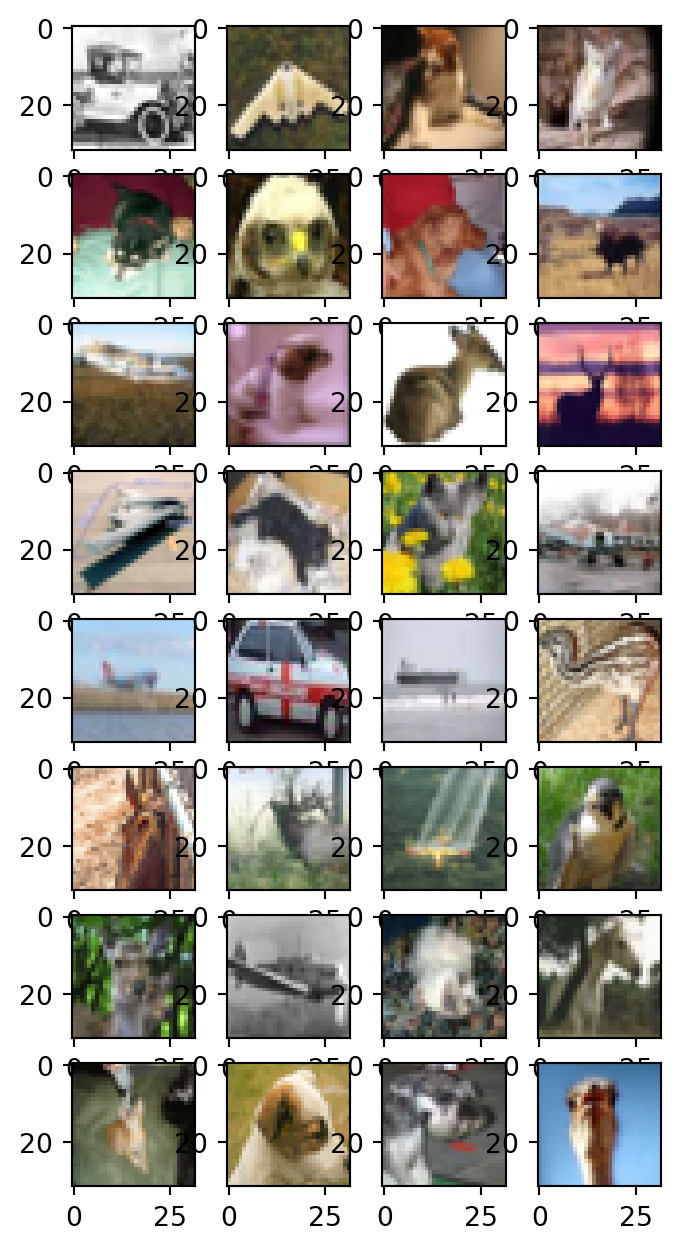

In [19]:
categories = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

predict = model.predict(x_test[0:500]).argmax(axis = 1)
label = y_test[0:500].argmax(axis = 1)
imgs = []
for i,v in enumerate(predict):
  ans = label[i]
  if v != ans:
    imgs += [x_test[i]]
    print('NG photo number:', i,', predict: ', categories[v], ', correct: ',  categories[ans])

show_imgs(imgs)

In [20]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

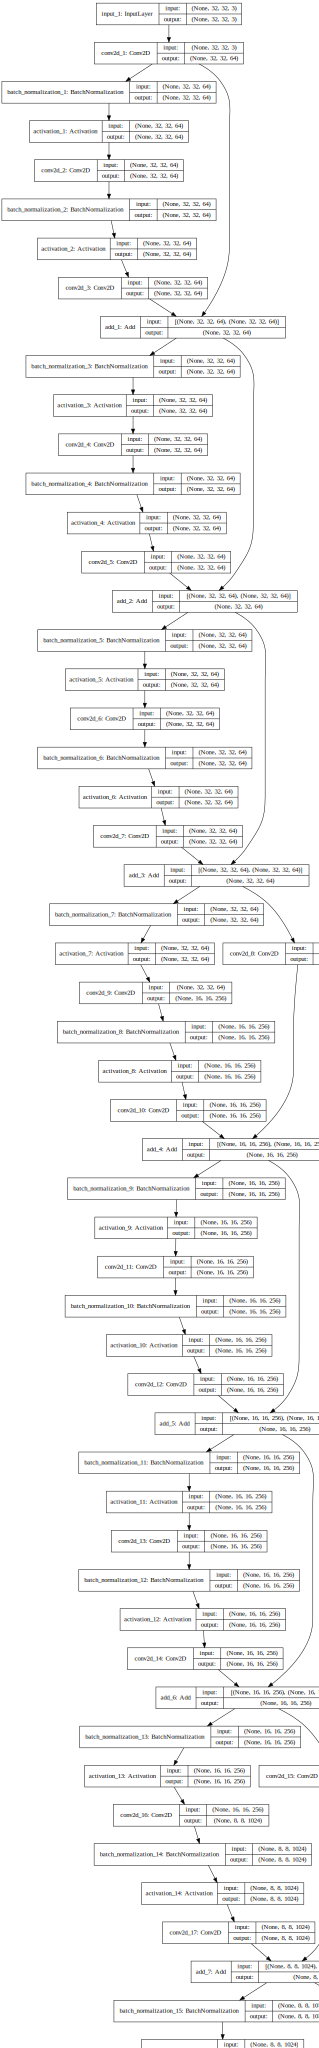

In [21]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes = True).create(prog='dot', format='svg'))

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
390/390 [==============================] - 102s 261ms/step - loss: 0.0900 - acc: 0.9695 - val_loss: 0.6308 - val_acc: 0.8733
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
390/390 [==============================] - 96s 247ms/step - loss: 0.0957 - acc: 0.9662 - val_loss: 0.3723 - val_acc: 0.9137
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
390/390 [==============================] - 96s 247ms/step - loss: 0.0992 - acc: 0.9664 - val_loss: 0.5136 - val_acc: 0.8933
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
390/390 [==============================] - 96s 246ms/step - loss: 0.0955 - acc: 0.9671 - val_loss: 0.4524 - val_acc: 0.8930
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.001.
390/390 [==============================] - 96s 246ms/step - loss: 0.0947 - acc: 0.9680 - val_loss: 0.3524 - 

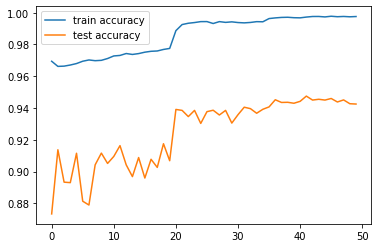

In [22]:
import matplotlib.pyplot as plt

#schedulerの設定
def step_decay(epoch):
    x = 0.001
    if epoch >= 20: x = 0.0003
    if epoch >= 35: x = 0.0001
    return x
decay = LearningRateScheduler(step_decay, verbose=1)
#datagen.fit(X_train)
#validationgen.fit(x_test)


#データ増大と学習率の変更をしない場合
#history = model.fit(x_train, y_train, batch_size=128, epochs = 10, verbose=1,validation_data=(x_test,y_test))

#データ増大と学習率の変更をする場合
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=128), 
                              steps_per_epoch=len(x_train) // 128, epochs=50, validation_data=(x_test,y_test),callbacks=[decay])


train_acc = history.history['acc']
test_acc = history.history['val_acc']
x = np.arange(len(train_acc))
plt.plot(x, train_acc, label = 'train accuracy')
plt.plot(x, test_acc, label = 'test accuracy')
plt.legend() #グラフの線の説明を表示